# Product Hypothesis

The original "Workhuman iQ Planning for Q2 '23" presentation is available [here](https://globoforce-my.sharepoint.com/:p:/r/personal/crystal_wheeldon_workhuman_com/_layouts/15/Doc.aspx?sourcedoc=%7BEE82EDDA-0585-4805-B7C3-086DD5F1A30B%7D&file=WHiQ%20App%20Q2%20Planning.pptx&_DSL=1&action=edit&mobileredirect=true).

The excerpt regarding turnover and retention is as follows: 

> Context: for Program Admins/HR Leadership (reporting to C-suite execs), on-demand turnover and retention metrics will provide the evidence they need for continued or increased investment in Recognition

> We believe that
> * By providing on-demand access to turnover and retention metrics as it relates (correlates, cf. Jesse's team) to Recognition activity
> * They will report a better, clearer understanding of ROI after 6 months
> * and will access these metrics through the Product 20% more after 3 months
> * allowing us to scale this capability to all strategic/enterprise customers by year-end
> * thus reducing the amount of ad-hoc requests to our CE teams

# Hypothesis Assessment (RAID Log)
The Engineering leadership team worked on analysing thes high-level requirements & build a RAID log, which is available [here](https://workhuman.atlassian.net/wiki/spaces/WA/pages/9614623445/Q2+Planning+Hypothesis+Assessment+RAID+Log).

## Definitions
* **Turnover** is defined as the proportion of your workforce who leave during a period of time (usually per year). 
* **Retention** is defined the proportion of employees who stay during a period of time.

# Product Design
The Figma designs created by the Product Design team are available [here](https://www.figma.com/file/wQJlWWcgx5zDy8o4OJdISt/WHiQ-GA?node-id=6080-82304&t=wIjHy0gNWY0ObK1D-0).

NB: these designs use the language "probability of leaving". We have received direction from Product that we will not be doing future predictive modelling for this project; we will instead focus on analyzing historical data and drawing inferences from this data.

## Screenshots from Product Design
NB: the below screenshots may not neccessarily represent the latest design (they are added to this notebook as screenshots to aid the reader's flow in understanding the problem domain). Please check the above Figma link or check with the Product Design team for the latest designs.

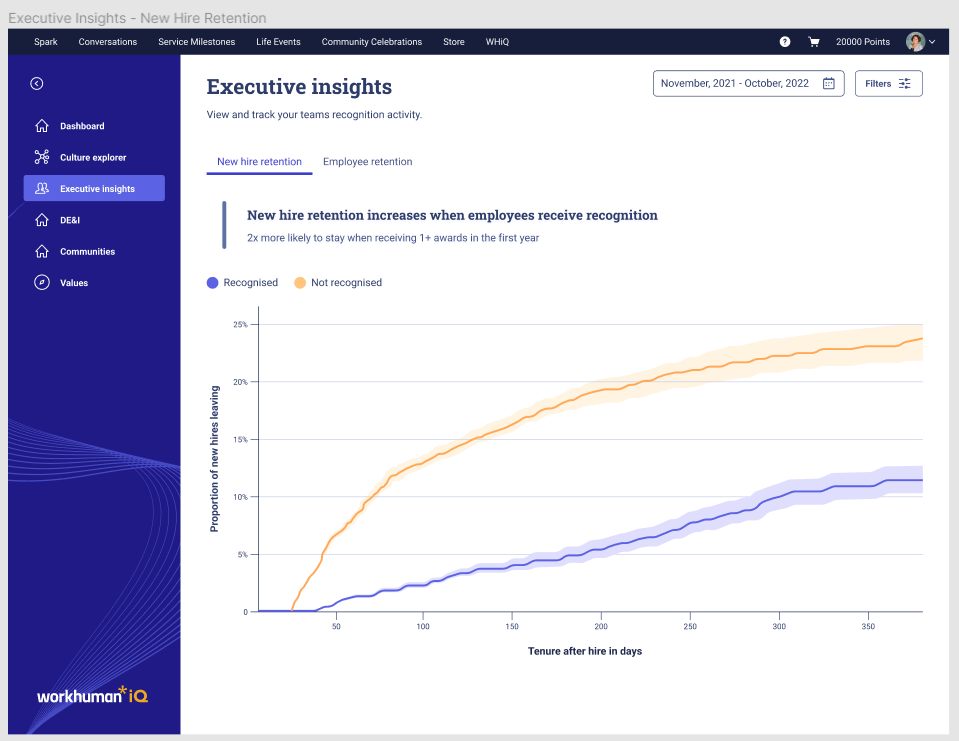

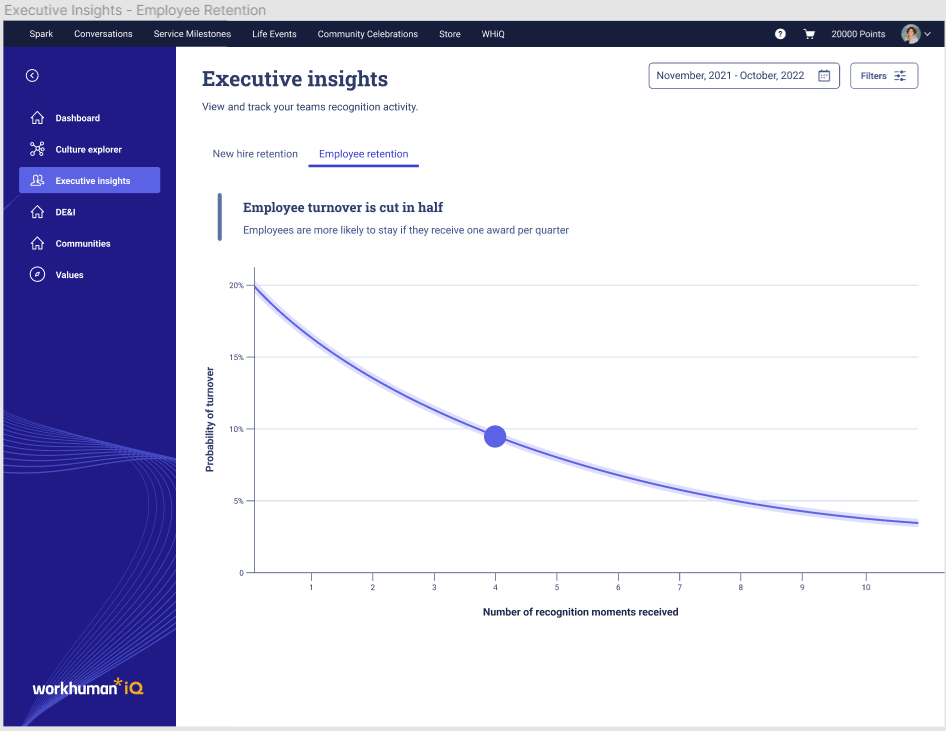

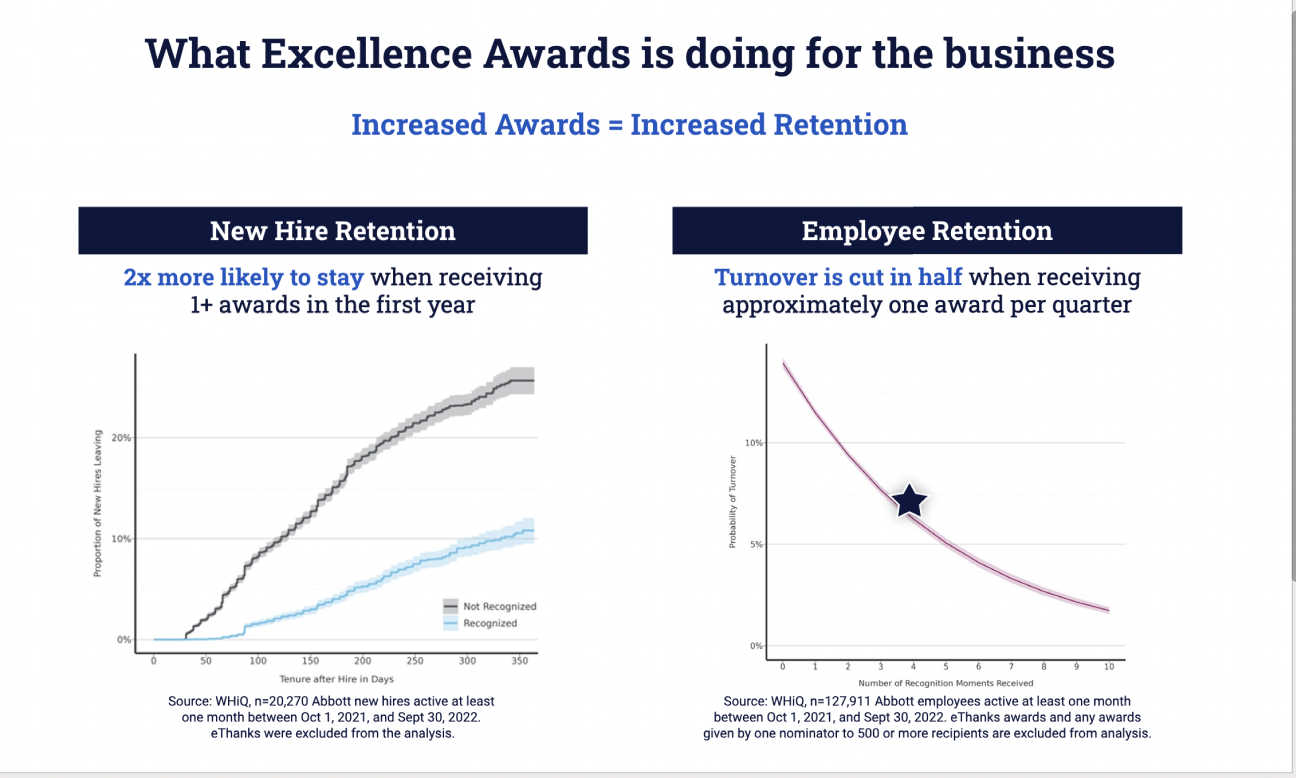

# High-Level Analysis of Product Designs
From the above product designs, it would appear that we need the following:
* Retention data bucketed by 
  * Client ID
  * Tenure After Hire
  * Number of Awards received

# Install 3rd party requirements

In [1]:
# Setting the pip config file to /dev/null was the quickest way to circumvent the need 
# to do authentication against aws codeartifact (my config file references aws codeartifact 
# as a source); you may not need/want to do this.
!PIP_CONFIG_FILE=/dev/null pip install \
  matplotlib \
  scipy \
  boto3 \
  pandas \
  redshift-connector 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Read Persons Data
We have an option to read from CSV or REDSHIFT. See the `data_source` var.

In [2]:
import pandas as pd
import boto3
from datetime import datetime, timedelta, date
import logging
import json
import redshift_connector
#from redshift_connector import InterfaceError

# Set the following var to control whether we load data from a CSV file or from redshift
data_source = 'CSV'
#data_source = 'REDSHIFT'


if data_source == 'CSV':
    persons_df = pd.read_csv("persons.csv")
elif data_source == 'REDSHIFT':
    # This was shamelessly lifted from the etl-pipeline-values-classification repo. It should be refined 
    # to take only what we need.
    PERSONS_QUERY = f"""
        SELECT p.pk_person as id,
            p.firstname  || ' '  || p.lastname person_name,
            dim.mgr as manager_id,
            dim.department_name,
            LEN(dim.manager_path)-LEN(REPLACE(dim.manager_path, '/', '')) as person_level,
            p.pk_client as client_id,
            clients.name as client_name,
            p.user_def3 as user_def3,
            p.expired as expired,
            p.created as created
        FROM ext_trusted_pii_oracle_gg_user.gg_ms_person p
        inner join ext_trusted_pii_oracle_gg_user.bi_dim_person dim on p.pk_person = dim.pk_person
        inner join ext_trusted_pii_oracle_gg_user.gg_ms_clients clients on dim.fk_client = clients.pk_client
        where 1 =1
            and p.pk_client in (%(client_ids)s)
            and (p.created >= '%(from_date)s' or p.modified >= '%(from_date)s')
    """


    def get_persons_data(cursor, client_list, from_date: datetime) -> pd.DataFrame:
        """ Extract persons data from redshift cluster

        :param cursor: Redshift connection cursor
        :param client_list: list of client ids to get person data for
        :param from_date: The datetime from which we want to query for updates to Persons data
        :return: Dataframe containing persons data, indexed by person ID
        """

        # TODO: conditionally filter persons using created & modified dates
        #  https://workhuman.atlassian.net/browse/ITS-306
        updated_persons_query = PERSONS_QUERY % {
            'client_ids': ",".join(map(str, client_list)),
            'from_date': from_date
        }
        logging.info(f"SQL query for extracting persons data : {updated_persons_query}")
        cursor.execute(updated_persons_query)
        df: pd.DataFrame = cursor.fetch_dataframe()
        return df.set_index(keys='id')


    def get_ssm_parameter_value(param):
        loaded_param = boto3.client("ssm").get_parameter(Name=param, WithDecryption=True)
        return loaded_param["Parameter"]["Value"]

    region_name = "eu-west-1"
    secret_id = 'datalake-app-matrix-app-user'
    redshift_db = 'redshiftpoc'
    # TODO: use ssm value to avoid incongruence
    #redshift_host = get_ssm_parameter_value("/matrix/values-classification/redshift-cluster-host")
    redshift_host = "redshift-cluster-poc.cwmze4zouw1m.eu-west-1.redshift.amazonaws.com"


    redshift_secret = boto3 \
            .client(service_name="secretsmanager", region_name=region_name) \
            .get_secret_value(SecretId=secret_id)
    redshift_secret = json.loads(redshift_secret['SecretString'])

    persons_from_date = date(1970, 1, 1)

    conn = redshift_connector.connect(
        host=redshift_host,
        user=redshift_secret['username'],
        password=redshift_secret['password'],
        database=redshift_db
    )
    with conn.cursor() as cursor:
        persons_df = get_persons_data(cursor, [33], persons_from_date)



persons_df

id             person_name  manager_id      department_name  \
0     22597915            Nryth Rconhl  12319221.0           Operations   
1     22597926           Axffual Hapuy  14866910.0         Global Sales   
2     22597919  Umiyjeoh Hvxzoi Knglkb  16184045.0           Operations   
3     22597924   Kdi Srmzxdqa Tbloauti   6992516.0              Finance   
4     24793309           Tmw Fhvtulesw  15719053.0            Marketing   
...        ...                     ...         ...                  ...   
2503  19294694           Ibzm Q'Nrasdy         NaN              Product   
2504  21460418          Xyjuw IjMrgfuo         NaN     Customer Success   
2505  11104804   Yscskhdaps Prcrzxmasp   6887417.0              Product   
2506  20849532          Fdiwxlq Skovts   2563555.0  Customer Excellence   
2507  19651726         Lgxqsu Yzpdrshd  19436754.0              Product   

      person_level  client_id client_name user_def3           expired  \
0              7.0         33       staff       NaN               NaN   
1              7.0         33       staff       NaN               NaN   
2              7.0         33       staff       NaN               NaN   
3              8.0         33       staff       NaN               NaN   
4              6.0         33       staff       NaN               NaN   
...            ...        ...         ...       ...               ...   
2503           NaN         33       staff       NaN  15/02/2023 15:14   
2504           NaN         33       staff       NaN  18/11/2022 16:39   
2505           7.0         33       staff       NaN               NaN   
2506           6.0         33       staff       NaN               NaN   
2507           7.0         33       staff       NaN               NaN   

               created  
0     10/08/2022 20:58  
1     10/08/2022 20:58  
2     10/08/2022 20:58  
3     10/08/2022 20:58  
4     11/01/2023 16:02  
...                ...  
2503  04/01/2022 20:20  
2504  23/05/2022 15:10  
2505  23/04/2019 11:55  
2506  07/04/2022 13:48  
2507  25/01/2022 14:20  

[2508 rows x 10 columns]

In [3]:
# Clean Data

def clean_date(val):
    """
    Some service account type users have the below expiry date.
    We want to clean this, as it exceeds the max timestamp for pandas
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timestamp-limitations
    """
    # TODO: the ISO-formatted one is not working for some reason? (i.e., its not being removed)
    if val in ['31/12/9999 00:00', '9999-12-31 00:00:00']:
        return None
    return val

# Clean data
persons_df['expired'] = persons_df['expired'].apply(clean_date)
if data_source == 'CSV':
    format_str = '%d/%m/%Y %H:%M'
elif data_source == 'REDSHIFT':
    format_str = '%Y-%m-%d %H:%M:%S'
    
persons_df['expired'] = pd.to_datetime(persons_df['expired'], format=format_str)
persons_df['created'] = pd.to_datetime(persons_df['created'], format=format_str)




In [4]:
persons_df.head()

id             person_name  manager_id department_name  person_level  \
0  22597915            Nryth Rconhl  12319221.0      Operations           7.0   
1  22597926           Axffual Hapuy  14866910.0    Global Sales           7.0   
2  22597919  Umiyjeoh Hvxzoi Knglkb  16184045.0      Operations           7.0   
3  22597924   Kdi Srmzxdqa Tbloauti   6992516.0         Finance           8.0   
4  24793309           Tmw Fhvtulesw  15719053.0       Marketing           6.0   

   client_id client_name user_def3 expired             created  
0         33       staff       NaN     NaT 2022-08-10 20:58:00  
1         33       staff       NaN     NaT 2022-08-10 20:58:00  
2         33       staff       NaN     NaT 2022-08-10 20:58:00  
3         33       staff       NaN     NaT 2022-08-10 20:58:00  
4         33       staff       NaN     NaT 2023-01-11 16:02:00

In [5]:
# Validating "created" and expired with 2 known users

# https://cloud.workhuman.com/microsites/t/profile/UserProfile?personId=<id>
persons_df[persons_df.id.isin([14866911, 8596508])]

id      person_name  manager_id    department_name  person_level  \
32     8596508  Hjnnrj Rpitcoth         NaN     Global Product           NaN   
1403  14866911     Khbm Dgtohud         NaN  Global Technology           NaN   

      client_id client_name user_def3             expired             created  
32           33       staff       NaN 2022-07-07 16:29:00 2017-08-29 17:42:00  
1403         33       staff       NaN 2022-02-07 16:14:00 2021-02-04 13:19:00

In [6]:
# For this analysis, we will be reviewing turnover for the calendar year of 2022

start_date = datetime(2022, 1, 1)
end_date = start_date + timedelta(days=365)

In [7]:
# TODO: need to review this logic with Chinmay and Joe
num_starting_employees = len(persons_df[
    # The person's hire date was before the start_date
    (persons_df['created'] <= start_date) &
    # AND they either have not left the company at all OR they left after the start_date
    ((persons_df['expired'].notna()) | (persons_df['expired'] > start_date))
])
num_ending_employees = len(persons_df[
    # The persons' hire date was before the end_date
    (persons_df['created'] <= end_date) &
    # AND they either have not left the company at all OR they left after the end date
    (persons_df['expired'].notna()) | (persons_df['expired'] > end_date)
])
avg_num_employees = (num_starting_employees + num_ending_employees) / 2

num_starting_employees, num_ending_employees, avg_num_employees

(1113, 1195, 1154.0)

In [8]:
# Employees which left in this calendar year
employees_which_left = persons_df[(persons_df['expired'] > start_date) & (persons_df['expired'] <= end_date)]

In [9]:
# Turonver for this calendar year
len(employees_which_left) / avg_num_employees

0.1637781629116118

In [10]:
# TODO: update this to allow reading dynamically from a datastore (e.g. postgresql)

awards_df = pd.read_csv("awards.csv")


awards_df['award_creation_date'] = pd.to_datetime(awards_df['award_creation_date'], format='%Y-%m-%d')

# A complex model might require checking back 12mo from each person's expired date (if available).
# It should perhaps also only take account of those who have been workig at the company for a year?
# In this case, I will just take the preceding year's awards (i.e., compare 2021 awards with 2022 persons cohort)
# This is to keep the initial analysis simple.
awards_2021_df = awards_df[(awards_df['award_creation_date'] < end_date) & (awards_df['award_creation_date'] >= start_date)]

awards_2021_df

unique_nomination_id  recipient_id  nominator_id award_creation_date  \
0                 110302150      19066008       8133250          2022-07-19   
1                 110233450      11196447      16735191          2022-07-19   
2                 109029794      12370064      11204444          2022-06-28   
3                 109029793      11314242      11204444          2022-06-28   
4                 109050596      16508537       5170637          2022-06-28   
...                     ...           ...           ...                 ...   
91316             111181332      21587104      12370062          2022-07-29   
91317             111181377      13635744      12370062          2022-07-29   
91318             111181378      20568308      12370062          2022-07-29   
91319             111174438       7596575       8839615          2022-07-29   
91320             111210742       6726990       6150741          2022-07-29   

       client_id  
0             33  
1             33  
2             33  
3             33  
4             33  
...          ...  
91316         33  
91317         33  
91318         33  
91319         33  
91320         33  

[58326 rows x 5 columns]

In [11]:
awards_count_by_recipient = awards_2021_df.groupby('recipient_id').count().reset_index()
awards_count_by_recipient = awards_count_by_recipient[['recipient_id', 'unique_nomination_id']]
awards_count_by_recipient.columns = ['recipient_id', 'awards_count']

awards_count_by_recipient

recipient_id  awards_count
0            67028            24
1            67033            20
2            67035            96
3            67036            29
4            67041             5
...            ...           ...
1392      24404141             3
1393      24411023             1
1394      24411024            16
1395      24411025             1
1396      24411026             1

[1397 rows x 2 columns]

In [12]:
year_data = persons_df[(persons_df['created'] <= end_date) & 
                           ((persons_df['expired'] >= start_date) | persons_df['expired'].isna())]

persons_and_award_counts = year_data.merge(awards_count_by_recipient, left_on='id', right_on='recipient_id', how='left')
#persons_and_award_counts[persons_and_award_counts['awards_count'].notna()]

persons_and_award_counts['awards_count'] = persons_and_award_counts['awards_count'].fillna(0).astype(int)
persons_and_award_counts.sort_values("awards_count")

id        person_name  manager_id           department_name  \
1263  21575499  Dnqbaxqcj Mdvdjhp         NaN  Global Customer Strategy   
1363  23076419      Okuprb Ufjlxo   1484553.0              Global Sales   
1362  19436756        Twnz Gyrcla         NaN         Global Technology   
1360  23076418      Npvixtv Elhfq  11100947.0          Human Experience   
1093  16218228            Tugn Oq         NaN         Global Technology   
...        ...                ...         ...                       ...   
606    9432415     Qnqapcc Qasmil  15617081.0                   Finance   
30     8839615     Ohosmo Jvwdwbx   1241735.0                Operations   
821   12463830      Jbxqlsi Ocpae   2260757.0                Operations   
974   12463829    Hqkjxm Zwrafyep   2260757.0                Operations   
1153  10760360      Hpww Vqdpplwh   2260757.0                Operations   

      person_level  client_id client_name user_def3             expired  \
1263           NaN         33       staff       NaN 2022-09-13 13:57:00   
1363           5.0         33       staff       NaN                 NaT   
1362           NaN         33       staff       NaN 2022-03-28 14:25:00   
1360           5.0         33       staff       NaN                 NaT   
1093           NaN         33       staff       NaN 2022-01-18 14:54:00   
...            ...        ...         ...       ...                 ...   
606            6.0         33       staff       NaN                 NaT   
30             5.0         33       staff       NaN                 NaT   
821            6.0         33       staff       NaN                 NaT   
974            6.0         33       staff       NaN                 NaT   
1153           6.0         33       staff       NaN                 NaT   

                 created  recipient_id  awards_count  
1263 2022-05-31 12:17:00           NaN             0  
1363 2022-09-06 13:39:00           NaN             0  
1362 2022-01-12 14:22:00           NaN             0  
1360 2022-09-06 13:39:00           NaN             0  
1093 2021-07-20 10:08:00           NaN             0  
...                  ...           ...           ...  
606  2018-03-22 15:03:00     9432415.0           182  
30   2017-10-19 21:23:00     8839615.0           188  
821  2020-01-07 15:24:00    12463830.0           193  
974  2020-01-07 15:24:00    12463829.0           203  
1153 2019-02-04 10:54:00    10760360.0           227  

[1501 rows x 12 columns]

In [13]:
# TODO: hard-coded min/max

x = []
y = []
for i in range(0, 131, 5):
    start, end = i, i + 5
    filtered_paac = persons_and_award_counts[(persons_and_award_counts['awards_count'] >= start) & (persons_and_award_counts['awards_count'] <= end)]
    
    
    left_co = filtered_paac[filtered_paac['expired'].notna()]
    
    if filtered_paac.empty:
        continue
    turnover = round(len(left_co) / len(filtered_paac), 2)
    x.append(end)
    y.append(turnover)
    
    print(start, end, len(filtered_paac), len(left_co), turnover)
    
    
    

0 5 196 112 0.57
5 10 117 36 0.31
10 15 124 19 0.15
15 20 142 18 0.13
20 25 136 14 0.1
25 30 124 9 0.07
30 35 111 7 0.06
35 40 100 4 0.04
40 45 103 8 0.08
45 50 73 3 0.04
50 55 87 3 0.03
55 60 64 2 0.03
60 65 59 4 0.07
65 70 51 0 0.0
70 75 37 1 0.03
75 80 38 1 0.03
80 85 38 0 0.0
85 90 31 2 0.06
90 95 35 1 0.03
95 100 18 0 0.0
100 105 14 0 0.0
105 110 19 1 0.05
110 115 14 0 0.0
115 120 9 0 0.0
120 125 5 0 0.0
125 130 7 1 0.14
130 135 4 0 0.0


Text(0, 0.5, 'Y values')

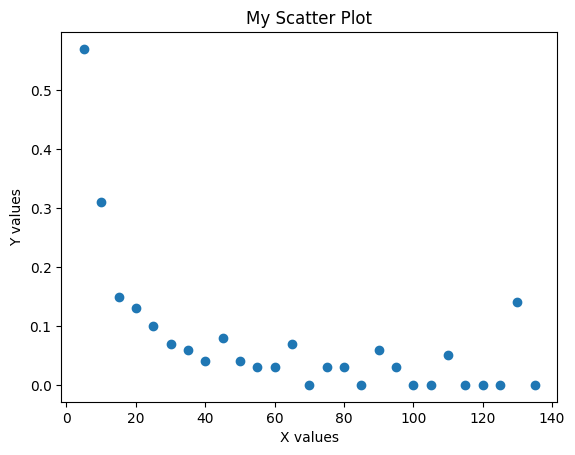

In [14]:
import matplotlib.pyplot as plt


# create scatter plot
plt.scatter(x, y)

# set chart title and axis labels
plt.title('My Scatter Plot')
plt.xlabel('X values')
plt.ylabel('Y values')


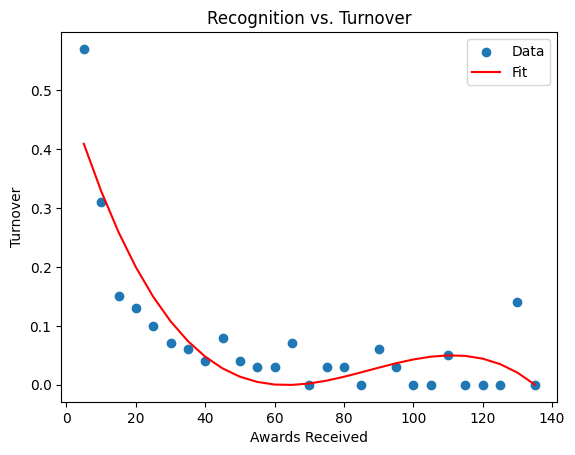

In [15]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

x = np.array(x)
y = np.array(y)

# define function to fit
def func(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# fit curve to data
popt, pcov = curve_fit(func, x, y)

# create scatter plot with fitted curve
plt.scatter(x, y, label='Data')
plt.plot(x, func(x, *popt), 'r-', label='Fit')
plt.title('Recognition vs. Turnover')
plt.xlabel('Awards Received')
plt.ylabel('Turnover')
plt.legend()
plt.show()